## Imports and dataset

In [1]:
from src.models.optimized_bnn import ClasBayesianNN
from src.attacks.distr_attacks_bnn_jax import mlmc_attack, fgsm_attack, kl_to_appd
from src.attacks.point_attacks_jax import attack

from src.utils import plot_ppds

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed

/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
import numpyro
numpyro.set_host_device_count(8)

In [4]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)

## MNIST - DE

In [5]:
# load MNIST data without tensorflow
from sklearn.datasets import fetch_openml

# Load MNIST from OpenML
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data.values, mnist.target.values
X = jnp.array(X) / 255.0  # Normalize pixel values to [0, 1]
y = y.astype(int)
y = jax.nn.one_hot(y, 10)

# Split into training and testing datasets
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

In [6]:
modelVI = ClasBayesianNNVI(input_dim=X_train.shape[1], hidden_units=30)
try:
    modelVI.load('../src/models/weights/mnist/30bnnvi')
except FileNotFoundError:
    print('Not model found, fitting the model') 
    modelVI.fit(
        X_train, 
        jnp.argmax(y_train, axis=1), 
        num_steps=5000
    )
    modelVI.save('../src/models/weights/mnist/30bnnvi')

In [7]:
# measure accuracy over the test set
y_pred = modelVI.sample_predictive_distribution(jax.random.PRNGKey(0), X_test, 1)
accuracy = (y_pred == jnp.argmax(y_test, axis=1)).mean()
print(f"Accuracy over the test set: {accuracy * 100:.2f}%")

Accuracy over the test set: 93.83%


In [8]:
# Load notMNIST data without labels
import os
from PIL import Image
import numpy as np

# Ruta de la carpeta con imágenes
folder_path = '../data/notMNIST_small'

# Lista para almacenar las imágenes
images = []

for dirpath, dirnames, filenames in os.walk(folder_path):
    for filename in filenames:
        if filename.endswith('.png'):
            img_path = os.path.join(dirpath, filename)
            img = Image.open(img_path)
            img_gray = img.convert('L')
            img_array = np.array(img_gray)
            images.append(img_array)

X_notmnist = np.array(images).reshape(-1, 28*28) / 255.0

In [9]:
def entropy(x, pred):
    pred += 1e-8
    entr = - (pred * jnp.log(pred)).sum(axis=-1) / jnp.log(2)
    return entr.mean()

In [10]:
def exp_entropy(x, y):
    return jax.nn.one_hot(y, 10).mean(axis=0)

In [11]:
x = X_test[0]
eps = 1
G = 20  # jnp.ones(10) / 10
x = jax.numpy.array(x.reshape(1, -1))
x_adv_values, loss_values, func_values = attack(x, modelVI, G, func=entropy, samples_per_iteration=50, epsilon=eps, num_iterations=1000)
preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv_values[-1], 20)
print(entropy(x_adv_values[-1], preds))
print(entropy(x, modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)))
print(jnp.linalg.norm(x - x_adv_values[-1]))

0.00019394464
0.00019394464
1.0000001


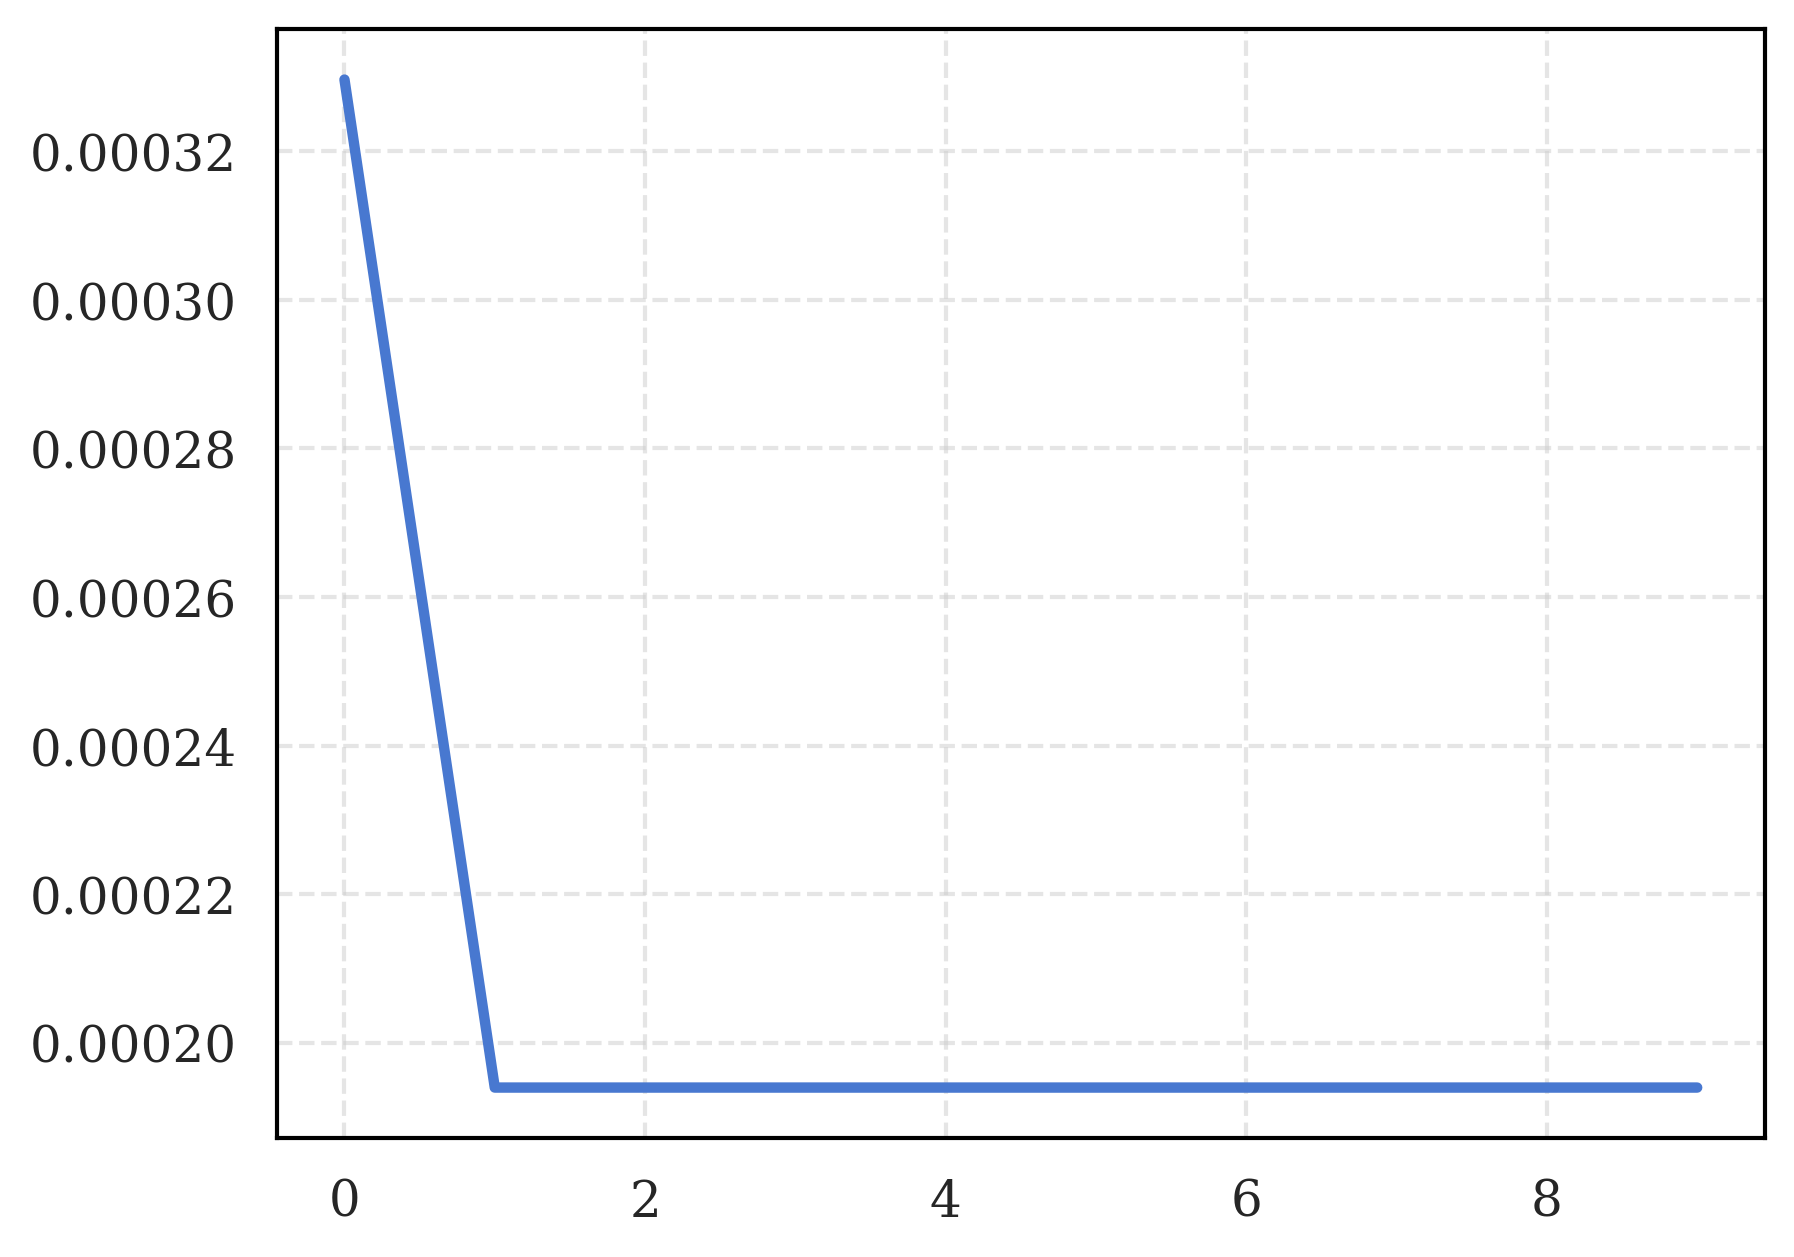

In [12]:
plt.plot(func_values)

## Baseline

In [13]:
unattacked_entropies = []
for x in tqdm(X_test[:100]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
legend = ['mnist', 'not mnist']
unattacked_entropies = []
for x in tqdm(X_notmnist[:100]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
plt.legend(legend)

python(81732) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
  9%|▉         | 9/100 [00:02<00:25,  3.63it/s]


KeyboardInterrupt: 

## Point attacks

100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


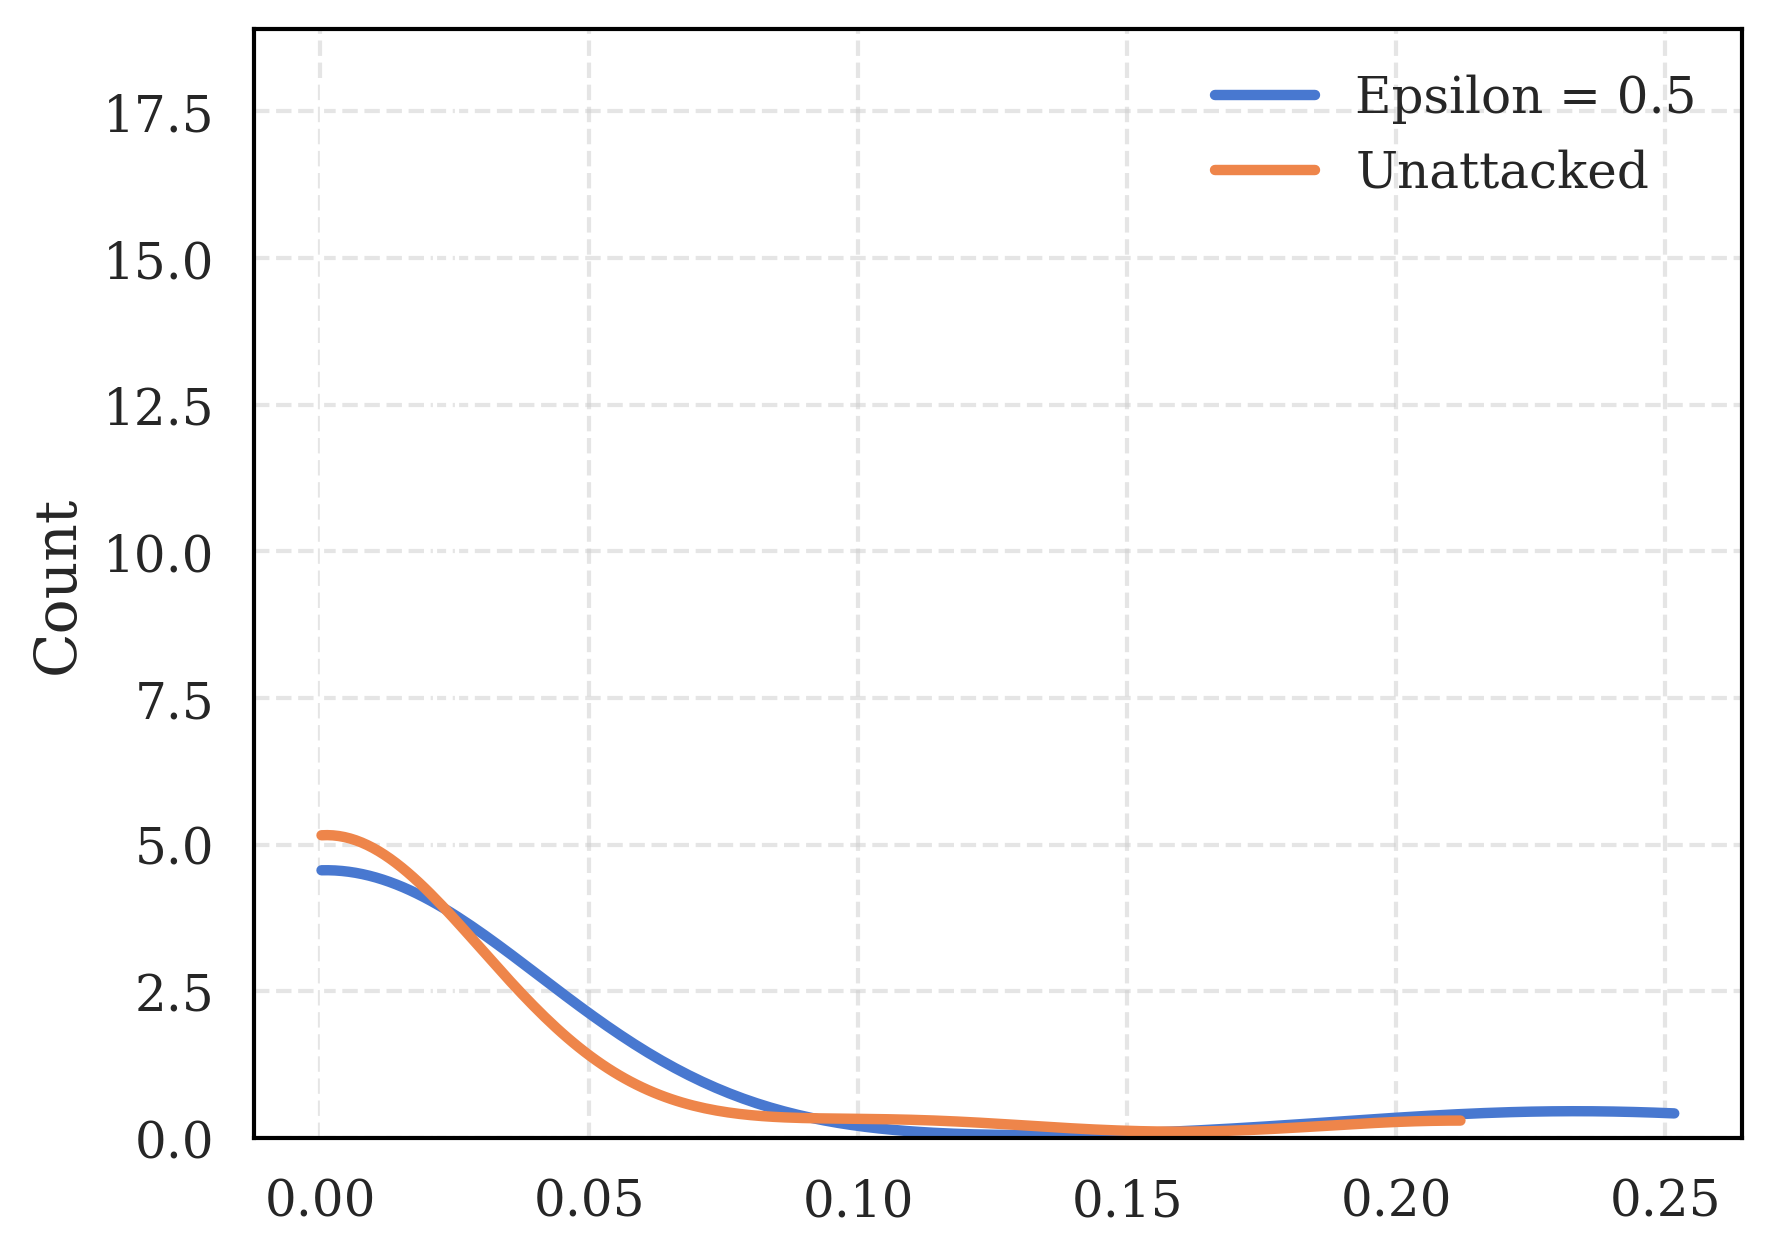

In [14]:
G = 20  # we want to rise the entropy of the predictive distribution

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv_values, loss_values, func_values = attack(x, modelVI, G, func=entropy, samples_per_iteration=20, epsilon=eps, num_iterations=1000)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv_values[-1], 20)
    return entropy(x_adv_values[-1], preds)

epsilons = [0.5]
num_points = 20
for eps in epsilons:
    #entropies = Parallel(n_jobs=8)(delayed(process)(x, eps) for x in tqdm(X_test[:num_points]))
    entropies = [process(x, eps) for x in tqdm(X_test[:num_points])]
    sns.histplot(jnp.array(entropies), kde=True, bins=10, alpha=0.)
    
unattacked_entropies = []
for x in tqdm(X_test[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
legend = ['Epsilon = ' + str(eps) for eps in epsilons] + ['Unattacked']
plt.legend(legend)

100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


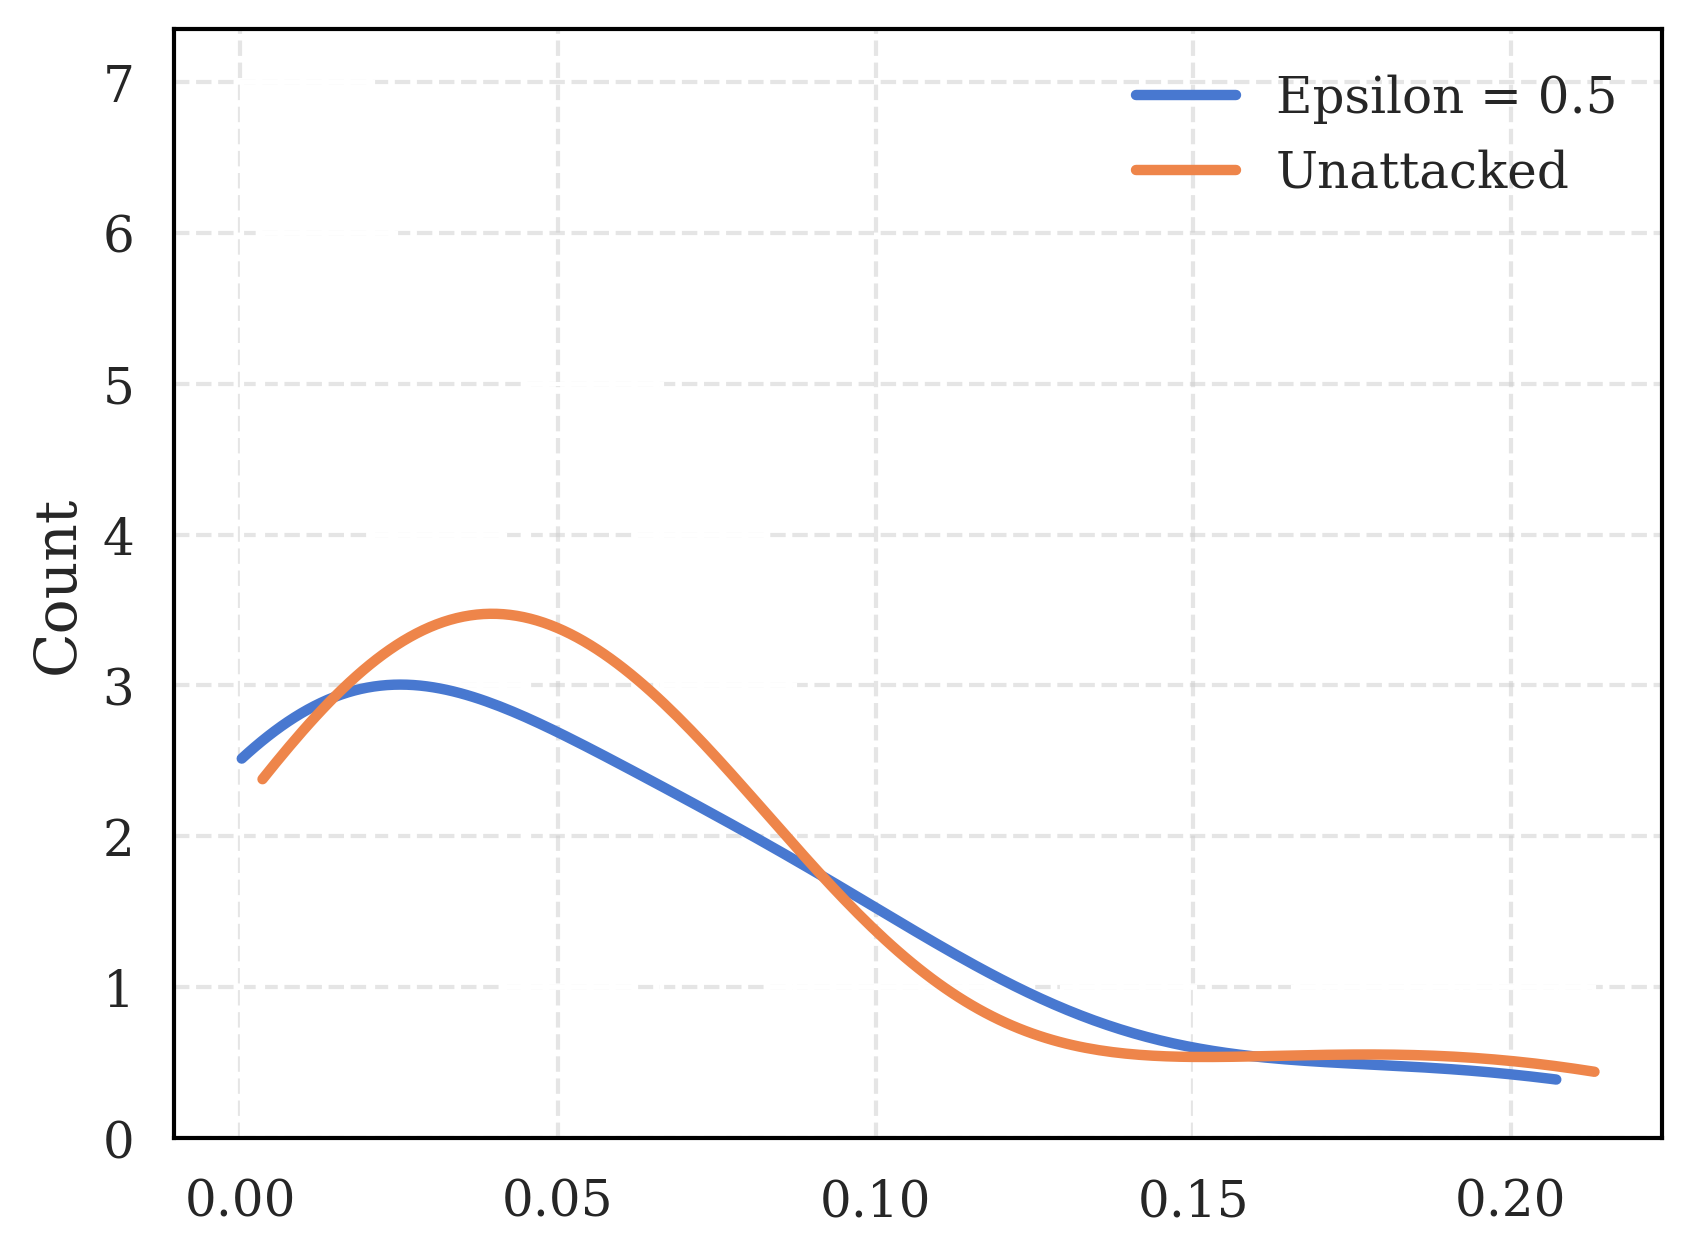

In [17]:
G = 0  # we want to lower the entropy of the predictive distribution

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv_values, loss_values, func_values = attack(x, modelVI, G, func=entropy, samples_per_iteration=20, epsilon=eps, num_iterations=1000)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv_values[-1], 20)
    return entropy(x_adv_values[-1], preds)

epsilons = [0.5]
num_points = 20
for eps in epsilons:
    #entropies = Parallel(n_jobs=8)(delayed(process)(x, eps) for x in tqdm(X_test[:num_points]))
    entropies = [process(x, eps) for x in tqdm(X_notmnist[:num_points])]
    sns.histplot(jnp.array(entropies), kde=True, bins=10, alpha=0.)
    
unattacked_entropies = []
for x in tqdm(X_notmnist[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
legend = ['Epsilon = ' + str(eps) for eps in epsilons] + ['Unattacked']
plt.legend(legend)

## Distribution attacks

  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at iteration 12


  5%|▌         | 2/40 [02:33<56:10, 88.70s/it]

Early stopping at iteration 12


  8%|▊         | 3/40 [02:38<31:07, 50.47s/it]

Early stopping at iteration 12


 10%|█         | 4/40 [02:42<19:18, 32.17s/it]

Early stopping at iteration 12


 12%|█▎        | 5/40 [02:46<12:49, 21.98s/it]

Early stopping at iteration 99


 18%|█▊        | 7/40 [05:20<31:20, 56.98s/it]

Early stopping at iteration 12


 25%|██▌       | 10/40 [09:34<42:19, 84.64s/it]

Early stopping at iteration 12


 30%|███       | 12/40 [11:44<37:20, 80.03s/it]

Early stopping at iteration 73


 32%|███▎      | 13/40 [12:09<28:28, 63.29s/it]

Early stopping at iteration 12


 35%|███▌      | 14/40 [12:14<19:42, 45.50s/it]

Early stopping at iteration 12


 38%|███▊      | 15/40 [12:18<13:45, 33.01s/it]

Early stopping at iteration 12


 42%|████▎     | 17/40 [14:45<22:59, 59.98s/it]

Early stopping at iteration 12


 48%|████▊     | 19/40 [16:54<23:42, 67.72s/it]

Early stopping at iteration 12


 52%|█████▎    | 21/40 [19:01<22:27, 70.91s/it]

Early stopping at iteration 12


 57%|█████▊    | 23/40 [21:10<20:39, 72.92s/it]

Early stopping at iteration 12


 60%|██████    | 24/40 [21:15<14:00, 52.52s/it]

Early stopping at iteration 12


 62%|██████▎   | 25/40 [21:19<09:29, 38.00s/it]

Early stopping at iteration 12


 68%|██████▊   | 27/40 [23:26<12:14, 56.49s/it]

Early stopping at iteration 12


 70%|███████   | 28/40 [23:31<08:11, 40.99s/it]

Early stopping at iteration 12


 72%|███████▎  | 29/40 [23:35<05:29, 29.94s/it]

Early stopping at iteration 12


 75%|███████▌  | 30/40 [23:39<03:41, 22.17s/it]

Early stopping at iteration 136


 78%|███████▊  | 31/40 [24:23<04:16, 28.50s/it]

Early stopping at iteration 12


 85%|████████▌ | 34/40 [28:45<07:35, 75.99s/it]

Early stopping at iteration 185


 90%|█████████ | 36/40 [31:41<05:39, 84.78s/it]

Early stopping at iteration 12


 92%|█████████▎| 37/40 [31:46<03:02, 60.89s/it]

Early stopping at iteration 12


 98%|█████████▊| 39/40 [33:53<01:07, 67.57s/it]

Early stopping at iteration 12


100%|██████████| 40/40 [00:18<00:00,  2.21it/s]


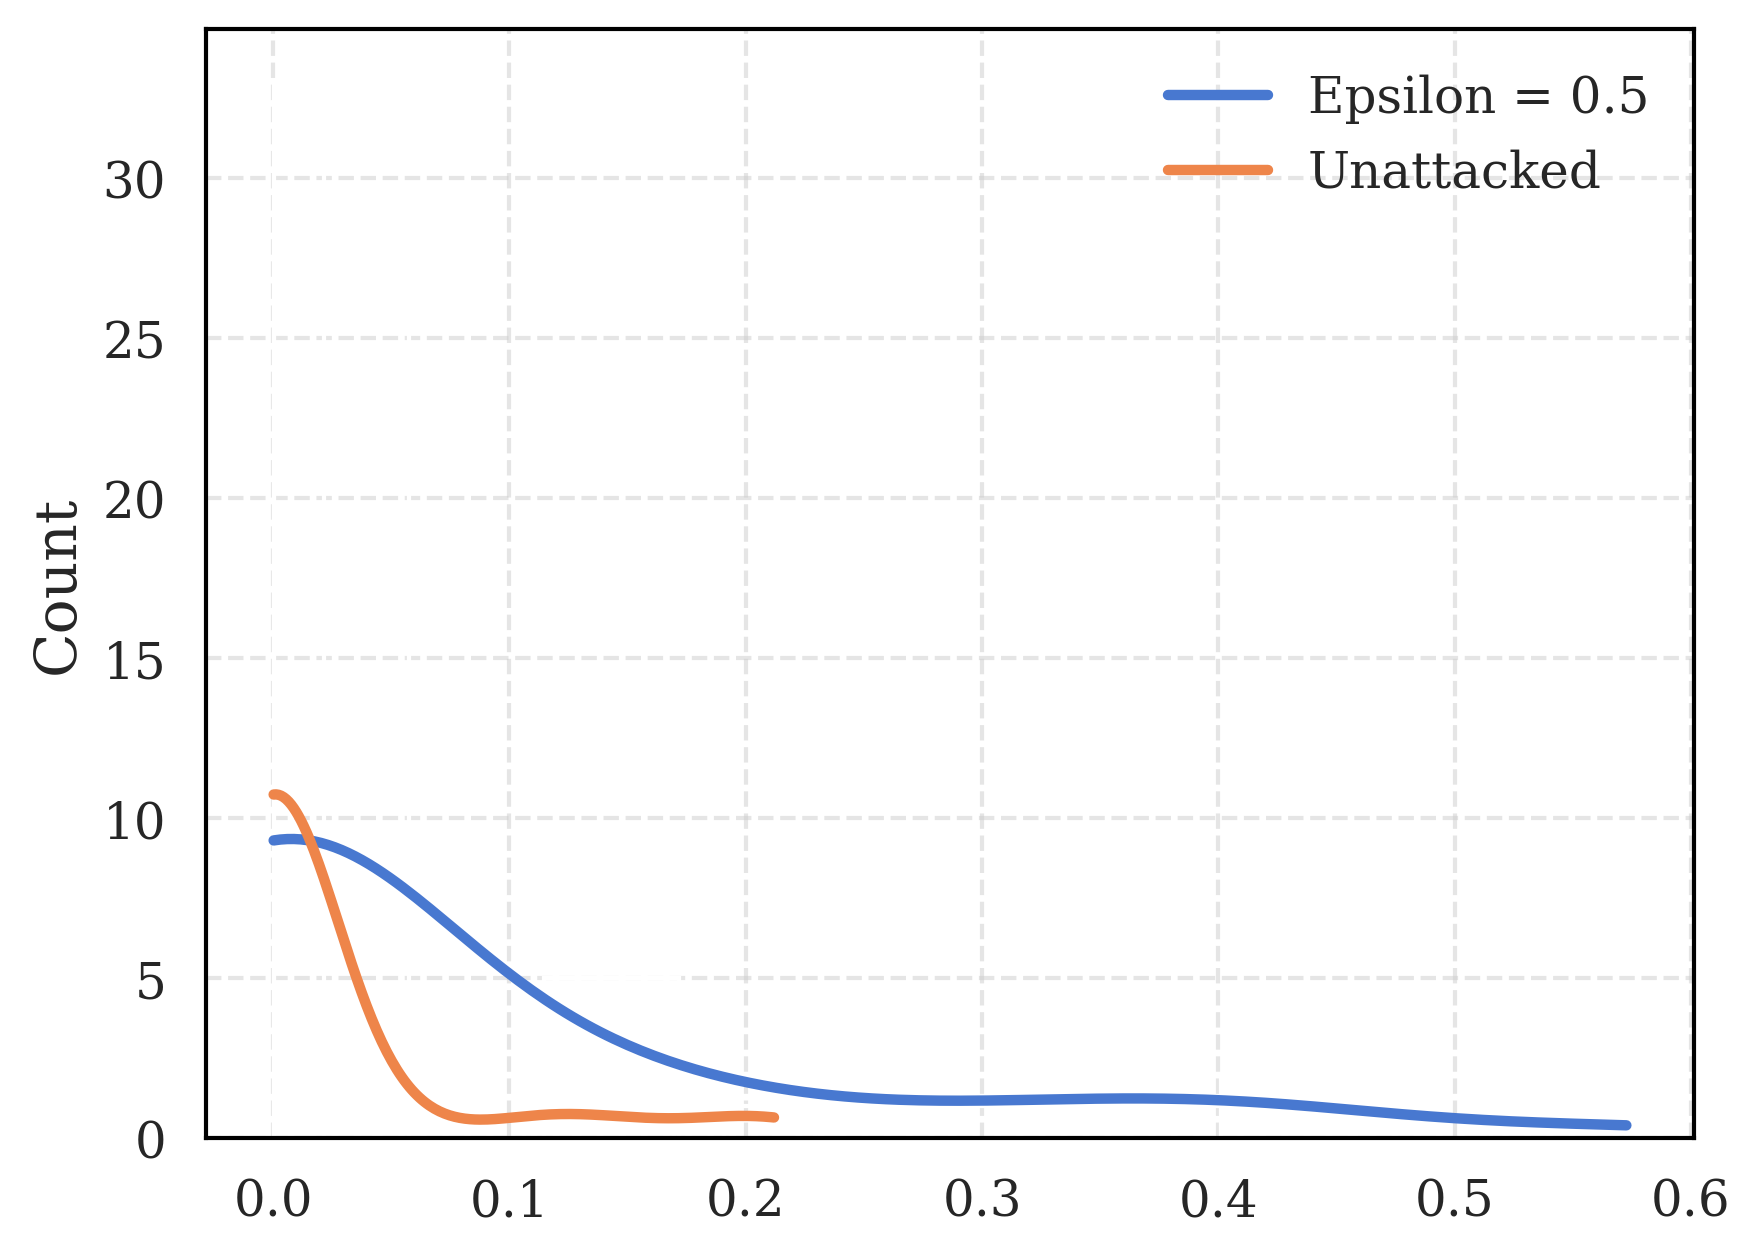

In [ ]:
# Y is a uniform distribution over 10 classes
obj_appd = numpyro.distributions.Categorical(jnp.ones(10) / 10)

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv, _ = mlmc_attack(modelVI, x, appd=obj_appd, epsilon=eps, n_iter=400, lr=0.01)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv, 20)
    return entropy(x_adv, preds)

epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
epsilons = [.5]
num_points = 40
for eps in epsilons:
    #entropies = Parallel(n_jobs=4)(delayed(process)(x, eps) for x in tqdm(X_test[:80]))
    entropies = [process(x, eps) for x in tqdm(X_test[:num_points])]
    sns.histplot(jnp.array(entropies), kde=True, bins=10, alpha=0.)
    
unattacked_entropies = []
for x in tqdm(X_test[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
legend = ['Epsilon = ' + str(eps) for eps in epsilons] + ['Unattacked']
plt.legend(legend)

In [16]:
def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    pred = modelVI.sample_predictive_distribution(jax.random.PRNGKey(0), x, 1)  # so obj_appd is just 1 point mass on pred
    obj_appd = numpyro.distributions.Categorical(probs=jax.nn.one_hot(pred, 10))
    
    x_adv, _ = mlmc_attack(modelVI, x, appd=obj_appd, epsilon=eps, n_iter=400)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv, 20)
    return entropy(x_adv, preds)

epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
epsilons = [0.5]
num_points = 40
for eps in epsilons:
    #entropies = Parallel(n_jobs=4)(delayed(process)(x, eps) for x in tqdm(X_notmnist[:8]))  # TODO 80 points
    entropies = [process(x, eps) for x in tqdm(X_notmnist[:num_points])]
    sns.histplot(jnp.array(entropies), kde=True, bins=10, alpha=0.)

unattacked_entropies = []
for x in tqdm(X_notmnist[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution(x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
legend = ['Epsilon = ' + str(eps) for eps in epsilons] + ['Unattacked']
plt.legend(legend)

 10%|█         | 4/40 [09:23<1:22:42, 137.84s/it]